# Question 1

*Question Description* <br>
* a. What are the FF factor betas for each of the industry portfolios? In regression, does it help to use 5 or 6 (includes MOM) factors or was original 3 or 4 (includes MOM) factors model adequate? Are these betas time varying?
* b. What regression technique can one employ to find more stable beta? How do your results change?

## Answer 1.a (1)

In [1]:
##import packages
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import scipy.stats as stats

/Users/xiaomanzhang/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
##import prepared datasets
FF_data = pd.read_csv('F_F_Factors.csv').set_index('Date')
FF_data = FF_data/100
portfolio_return = pd.read_csv('Portfolios_returns.csv').set_index('Date')
portfolio_return = portfolio_return/100

#### Simple Data Check 

In [3]:
##Check if there is any missing values in the FF factor dataset
np.sum(FF_data.isnull(), 0)

Mkt-RF    0
SMB       0
HML       0
RMW       0
CMA       0
MOM       0
RF        0
dtype: int64

In [4]:
##Check if there is any missing values in the portfolio return dataset
np.sum(portfolio_return.isnull(), 0)

NoDur    0
Durbl    0
Manuf    0
Enrgy    0
Chems    0
BusEq    0
Telcm    0
Utils    0
Shops    0
Hlth     0
Money    0
Other    0
dtype: int64

There is no missing values in the FF factor dataset and portfolio return dataset

In [5]:
##check the normality of FF factors
stats.normaltest(FF_data).pvalue

array([5.65868113e-15, 3.19232853e-13, 1.38247104e-07, 1.26866795e-22,
       2.73391863e-07, 8.61655028e-41, 8.97684856e-21])

In [6]:
##check the normality of portfolio returns
stats.normaltest(portfolio_return).pvalue

array([1.99378517e-11, 1.17807465e-18, 5.43461721e-17, 2.86439934e-11,
       4.56449245e-12, 3.77026369e-06, 7.16896691e-05, 2.80106965e-06,
       2.99689101e-12, 1.19201485e-04, 4.35272857e-12, 3.39922225e-19])

From the normal test result, we can assume all the time series follows normal distribution, and we will not perform additional outlier removing or other data cleaning/standardization processes for the datasets.

In [7]:
##define factor combinations to test
factor_comb = {'FF3': ['Mkt-RF', 'SMB', 'HML'],
                      'CFF': ['Mkt-RF', 'SMB', 'HML', 'MOM'],
                      'FF5': ['Mkt-RF', 'SMB', 'HML', 'MOM', 'RMW'],
                      'CFF_CMA': ['Mkt-RF', 'SMB', 'HML', 'MOM', 'CMA'],
                      'FF6': ['Mkt-RF', 'SMB', 'HML', 'MOM', 'RMW', 'CMA']}

##define columns to be shown in the result tables
result_table_cols = ['Alpha', 'Mkt-RF', 'SMB','HML','MOM', 'RMW', 'CMA','R_adj']
#result_table_cols = ['Alpha', 'Alpha_t', 'Mkt-RF', 'Mkt-RF_t',
#                     'SMB', 'SMB_t','HML', 'HML_t', 'MOM', 'MOM_t',
#                     'RMW', 'RMW_t','CMA', 'CMA_t','R_adj']

**OLS**

In [8]:
##This function is to perform OLS on the factor models, and return the regression results in tables

def generate_reg_result(portfolio, portfolio_return, FF_data, factor_comb, result_table_cols):
    
    #create empty table to store the regression results
    reg_result = np.empty((len(factor_comb), len(result_table_cols)))
    reg_result[:] = np.nan
    reg_result = pd.DataFrame(reg_result)
    reg_result.columns = result_table_cols
    reg_result.index = factor_comb.keys()

    ##fill the table with regression result
    #iterate the factor combinations to test
    for comb in factor_comb:
        #define the dependent and independent variables
        y = np.array(portfolio_return[portfolio]-FF_data['RF'])
        X = np.array(FF_data[factor_comb[comb]])
        #add constant term
        X = sm.add_constant(X)
        #OLS
        reg = sm.OLS(y, X).fit()
        #fill the result table with output parameters
        reg_result.loc[comb]['Alpha'] = reg.params[0]
        #reg_result.loc[comb]['Alpha_t'] = reg.tvalues[0]
        reg_result.loc[comb]['R_adj'] = reg.rsquared_adj
        for i in range(len(factor_comb[comb])):
            reg_result.loc[comb][factor_comb[comb][i]] = reg.params[i+1]
            #reg_result.loc[comb][factor_comb[comb][i]+'_t'] = reg.tvalues[i+1]
    #export the result table to csv files
    #reg_result.to_csv(portfolio+'reg_beta_result.csv')
    return reg_result

In [9]:
##This function is to plot the bar chart for different portfolios with various factor combinations

def bar_chart_plot(data, width, xlabel, ylabel):
    n = len(data.columns)
    m = len(data.index)
    x = np.arange(n)
    width_change = [width*i for i in range(-int(m//2), m//2+1)]
    plt.figure(figsize=(16, 9))
    for i in range(len(Adjusted_R2.index)):
        plt.bar(x+width_change[i], data.loc[data.index[i]], width)
    plt.xticks(x, list(data.columns))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(data.index)
    plt.show()

In [10]:
## This function is to calculate the t_stats and Pvalues of the input data, and check if the difference between the group pairs is significant

def t_stats(data):
    t_stats = {}
    p_value = {}
    for i in range(len(data.index)-1):
        for j in range(i+1, len(data.index)):
            # Creating data groups
            data_group1 = data.loc[data.index[i]]
            data_group2 = data.loc[data.index[j]]
            # Perform the two sample t-test 
            test_result = stats.ttest_ind(a=data_group1, b=data_group2)
            t_stats[data.index[i]+'&'+data.index[j]] = test_result.statistic
            p_value[data.index[i]+'&'+data.index[j]] = test_result.pvalue
    return t_stats, p_value

Generate the regression results using the above functions and return the adjusted R2 for further analysis.

In [11]:
##generate the results for betas and adjusted R2
Adjusted_R2 = pd.DataFrame()
beta_results = {}
for portfolio in list(portfolio_return.columns):
    print('----------------------------------------------------')
    print(portfolio)
    reg_result = generate_reg_result(portfolio, portfolio_return, FF_data, factor_comb, result_table_cols)
    beta_results[portfolio] = reg_result
    print(reg_result)
    Adjusted_R2[portfolio] = reg_result['R_adj']

----------------------------------------------------
NoDur
            Alpha    Mkt-RF       SMB       HML       MOM       RMW       CMA  \
FF3      0.002277  0.729883 -0.204701  0.200785       NaN       NaN       NaN   
CFF      0.001930  0.744096 -0.205295  0.218038  0.050358       NaN       NaN   
FF5     -0.000222  0.781661 -0.027333  0.095265  0.033624  0.523306       NaN   
CFF_CMA  0.001166  0.779028 -0.210302  0.075365  0.031345       NaN  0.326338   
FF6     -0.001338  0.828660 -0.022043 -0.094682  0.008286  0.557631  0.416049   

            R_adj  
FF3      0.620383  
CFF      0.622416  
FF5      0.696360  
CFF_CMA  0.636463  
FF6      0.719642  
----------------------------------------------------
Durbl
            Alpha    Mkt-RF       SMB       HML       MOM       RMW       CMA  \
FF3     -0.001697  1.354235  0.247485  0.309847       NaN       NaN       NaN   
CFF      0.000578  1.261039  0.251377  0.196715 -0.330218       NaN       NaN   
FF5     -0.000606  1.281703  0.3

In [12]:
##print the adjusted R2
Adjusted_R2

,NoDur,Durbl,Manuf,Enrgy,Chems,BusEq,Telcm,Utils,Shops,Hlth,Money,Other
FF3,0.620383,0.593559,0.864719,0.479404,0.687841,0.833727,0.640599,0.317599,0.751607,0.563764,0.858814,0.891763
CFF,0.622416,0.623521,0.866074,0.479183,0.687360,0.839047,0.642270,0.329608,0.751210,0.570912,0.861219,0.892367
FF5,0.696360,0.628242,0.880390,0.478478,0.731696,0.850656,0.648503,0.333186,0.793998,0.575504,0.860984,0.895654
CFF_CMA,0.636463,0.622797,0.866368,0.483385,0.697033,0.842381,0.650338,0.349887,0.752014,0.586867,0.868910,0.892167
FF6,0.719642,0.627392,0.881618,0.483154,0.747308,0.855796,0.654965,0.356361,0.793695,0.594088,0.868995,0.895606


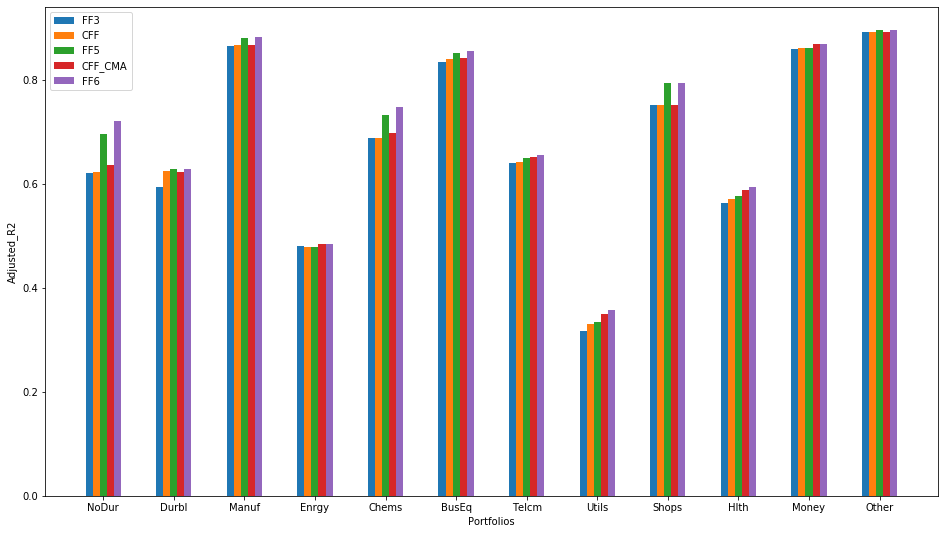

In [13]:
##Use bar chart to show the tendency of adjusted R2
bar_chart_plot(Adjusted_R2, 0.1, 'Portfolios', 'Adjusted_R2')

**t-test**

In [14]:
##Use t-stats to show if there is a big difference between the Adjusted R2 among different factor models
t, p = t_stats(Adjusted_R2)
print(p)

{'FF3&CFF': 0.9430936982254641, 'FF3&FF5': 0.7558157584860876, 'FF3&CFF_CMA': 0.8646165528418718, 'FF3&FF6': 0.6619613299170486, 'CFF&FF5': 0.8085041202468058, 'CFF&CFF_CMA': 0.9210611952417307, 'CFF&FF6': 0.712132942748938, 'FF5&CFF_CMA': 0.882872782834146, 'FF5&FF6': 0.9022817115794796, 'CFF_CMA&FF6': 0.7836198909156191}


### Conclusions

We used Adjusted R2 to measure the model performance because it measures to which extend the dependent variable can be explained by the independent variables. But unlike R2, which will always increase by adding more independent variables, the adjusted R2 adds precision and reliability by considering the impact of additional independent variables that tend to skew the results of R-squared measurements.<br>
<br>
The conclusions of this sub-section are: <br>
* 1. From the bar chart, we can observe an increase trend when adding factors 5 and/or 6 among the 12 portfolios, expecially for some of the portfolios (e.g., NoDur) the trend is obvious.
* 2. However, we also performed the t-test to test the adjusted R2 difference between different factor models (with 12 samples for each test) and printed out the pvalues, but just found none of the test is significant. 
* 3. Based on the above two observations, we can conclude, for some of the portfolios, adding factor 5 and 6 will be helpful, but in general, FF3 and CFF should be adequate from the statistical perspective.

## Answer 1.a (2)

Next, I checked the time variation of the betas. For this purpose, I evenly divide the entire testing history into 12 pieces (~ 3 year a piece), and ploted the bar chart.

In [15]:
##This function is to calculate the average std per factor model and industry

def calc_beta_std(portfolio_return, FF_data, factor_comb, result_table_cols, reg_method):
    ## divide the time period in to 12 pieces (~3 year a piece)
    times = portfolio_return.index
    time_cuts = 12
    time_total = times.shape[0]

    #create an empty dataframe to store the beta std results
    beta_std_bytime = pd.DataFrame()
    std_total = {} #store the 3d matrix for each portfolios
    for portfolio in list(portfolio_return.columns):
        reg_panel = []
        for i in range(time_cuts):
            start = times[int(i * time_total / time_cuts)]
            end = times[min(int((i+1) * time_total / time_cuts), time_total-1)]
            #apply the predefined regression function to calculate the betas
            if reg_method == 'OLS':
                reg_result = generate_reg_result(portfolio, portfolio_return.loc[start: end], FF_data.loc[start: end], factor_comb, result_table_cols)
                reg_panel.append(reg_result) 
            elif reg_method == 'GLS':
                reg_result = generate_reg_result_GLS(portfolio, portfolio_return.loc[start: end], FF_data.loc[start: end], factor_comb, result_table_cols)
                reg_panel.append(reg_result) 
            elif reg_method == 'WLS':
                reg_result = generate_reg_result_WLS(portfolio, portfolio_return.loc[start: end], FF_data.loc[start: end], factor_comb, result_table_cols)
                reg_panel.append(reg_result) 
        
        #calculate the beta std along time cuts
        beta_std = np.std(reg_panel, axis = 0)
        #calculate the mean std of betas for each FF methods
        beta_std_bytime[portfolio] = np.nanmean(beta_std, axis = 1) 
    beta_std_bytime.index = factor_comb.keys()
    return beta_std_bytime

In [16]:
##Calculate the beta std of OLS
beta_std_bytime = calc_beta_std(portfolio_return, FF_data, factor_comb, result_table_cols, 'OLS')

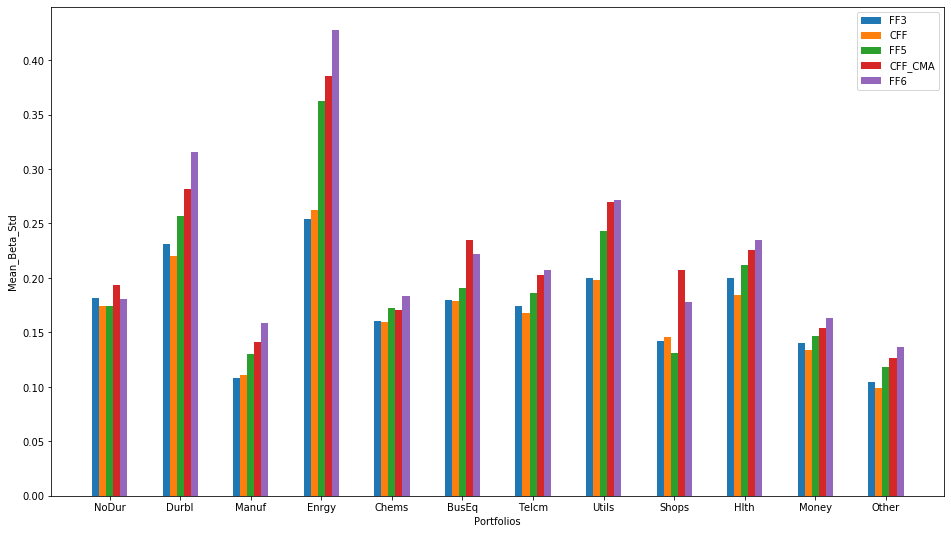

In [17]:
##Plot the bar chart on the beta standard deviations
bar_chart_plot(beta_std_bytime, 0.1, 'Portfolios', 'Mean_Beta_Std')

### Conclusions: 

* 1. There exists beta time variations (represented by beta standard deviations), and the time variations for different factors and different portfolios are different.
* 2. For some portfolios (e.g., Enrgy and Durbl), the beta time variations are generally greater than other portfolios.
* 3. There is a monotonic pattern for the beta variations among different FF factor models, generally the more complex the model, the greater the time variation, and adding the RMW and CMA factors will definitely increase such variations. One guess is adding the RMW and CMA factors will somehow add multicollinearity to the model or cause heteroscedasticity, which will be tested in the next sub-question. But they are not the only reasons to cause time variations in beta estimation. The market conditions change (e.g., crisis) and the industry cycle rotations can also be some reasons to cause the variation.

## Answer 1.b

As we observed the time variations for betas, and the variation increased with model complexity. It is probably there exists multicollinearity between factors. 

**Correlation Heatmap**

In [18]:
##Correlations between factors
#plot the correlation heatmap
import seaborn as sb
def correlation_calc(data, correlation_method = 'pearson'):
    plt.figure(figsize=(16, 9))
    heatmap = sb.heatmap(data.corr(method = correlation_method), cmap="YlGnBu",  annot=True)
    heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

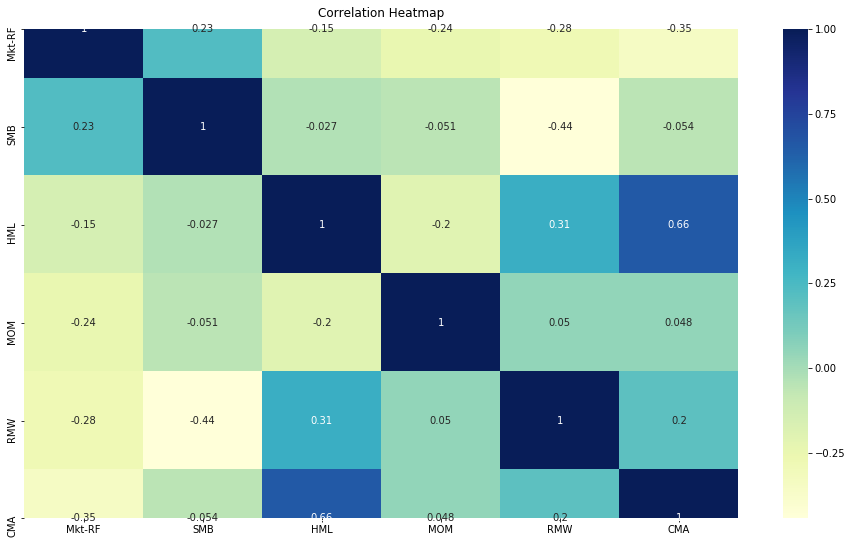

In [19]:
correlation_calc(FF_data[['Mkt-RF', 'SMB','HML','MOM', 'RMW', 'CMA']])

The heatmap shows overall the corrlations between factors are not high. The correlation between HML and CMA is relatively higher, which is 0.66. To make the conclusion more clear, I will use calculate the VIF for each factor to further explain.

**VIF**

In [20]:
##VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor
# VIF dataframe
vif_factors = pd.DataFrame()
vif_factors["factor"] = ['Mkt-RF', 'SMB','HML','MOM', 'RMW', 'CMA']
  
# calculating VIF for each factor
vif_factors["VIF"] = [variance_inflation_factor(FF_data[['Mkt-RF', 'SMB','HML','MOM', 'RMW', 'CMA']].values, i)
                          for i in range(len(vif_factors["factor"]))]
vif_factors

,factor,VIF
0,Mkt-RF,1.254654
1,SMB,1.287180
2,HML,2.156839
3,MOM,1.167149
4,RMW,1.441510
5,CMA,2.038768


The VIF for HML and CMA are relatively higher than the others, which is consistent with the result from the correlation heatmap. However, the values are far below 5, which we can regard there is no multicollinearity issue between factors. **And the time variation of betas are probably not caused by multicollinearity.** 

**Another reason that can cause variation in beta is heteroscedasticity.** When the errors are heteroskedastic and/or correlated, the variance of beta will be incorrect, which will further lead to errors in the calculation of standard errors, z-scores, p-values and confidence intervals of the estimated coefficients. Thus, in the next step, I will test the heteroscedasticity for the errors. Also, as we observed the 'Enrgy' portfolio has the largest variation, I will focus the investigation on this portfolio.

**White Test**

In [21]:
#import packages
from statsmodels.stats.diagnostic import het_white
from statsmodels.compat import lzip

#run the regression for 'Enrgy' portfolio for FF6 factor model
y = np.array(portfolio_return['Enrgy']-FF_data['RF'])
X = np.array(FF_data[factor_comb['FF6']])
X = sm.add_constant(X)
model = sm.OLS(y,X).fit()
#Perform White Test
resid = model.resid
white_test = het_white(model.resid,  model.model.exog)
#Zipping the array with labels
names = ['Lagrange multiplier statistic', 'p-value','f-value', 'f p-value']
#show the results
lzip(names,white_test)

[('Lagrange multiplier statistic', 115.93468362778185),
 ('p-value', 5.429521641159989e-13),
 ('f-value', 5.466250324946777),
 ('f p-value', 2.128940002236411e-15)]

The White Test is done by passing the residuals and all the independent variables. The White Test has the null hypothesis that the errors have same variance or homoscedastic. Having a p-value ≤ 0.05 would indicate that the null hypothesis is rejected, hence heteroscedasticity.

Thus, I performed the White Test for 'Enrgy' porfolio on FF6 factor model, and observed the p-value to be significantly less than 0.05. **This indicates there exists heteroscedasticity.** 

**Scatter Plot**

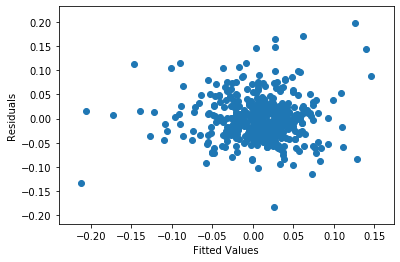

In [22]:
#Plot the residulas against the fitted values 
y_predicted  = model.predict(X)
plt.scatter(y_predicted, model.resid)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

As can been seen in the plot, the residuals become much more spread out as the fitted values get larger, so we again confirmed that there exists heteroscedasticity.

The way we want to deal with heteroscedasticity is to apply **Generalized Least Squares (GLS) model and Weighted Least Squares(WLS)**

**GLS**

In [23]:
##This function is to perform GLS on the factor models, and return the regression results in tables

from scipy.linalg import toeplitz
def generate_reg_result_GLS(portfolio, portfolio_return, FF_data, factor_comb, result_table_cols):
    ##create empty table to store the regression results
    reg_result_GLS = np.empty((len(factor_comb), len(result_table_cols)))
    reg_result_GLS[:] = np.nan
    reg_result_GLS = pd.DataFrame(reg_result)
    reg_result_GLS.columns = result_table_cols
    reg_result_GLS.index = factor_comb.keys()

    ##fill the table with regression result
    #iterate the factor combinations to test
    for comb in factor_comb:
        #define the dependent and independent variables
        y = np.array(portfolio_return[portfolio]-FF_data['RF'])
        X = np.array(FF_data[factor_comb[comb]])
        #add constant term
        X = sm.add_constant(X)
        #OLS
        reg = sm.OLS(y, X).fit()
        
        #Assume the residual follows AR(1) and calculate the coefficient to construct covariance matrix fed into the GLS regression
        ols_resid = reg.resid
        res_fit = sm.OLS(list(ols_resid[1:]), list(ols_resid[:-1])).fit()
        rho = res_fit.params
        #Construct the covariance matrix
        order = toeplitz(np.arange(len(ols_resid)))
        sigma = rho**order
        gls_model = sm.GLS(y, X, sigma=sigma)
        reg_GLS = gls_model.fit()
        #fill the result table with output parameters
        reg_result_GLS.loc[comb]['Alpha'] = reg_GLS.params[0]
        #reg_result_GLS.loc[comb]['Alpha_t'] = reg_GLS.tvalues[0]
        reg_result_GLS.loc[comb]['R_adj'] = reg_GLS.rsquared_adj
        for i in range(len(factor_comb[comb])):
            reg_result_GLS.loc[comb][factor_comb[comb][i]] = reg_GLS.params[i+1]
            #reg_result_GLS.loc[comb][factor_comb[comb][i]+'_t'] = reg_GLS.tvalues[i+1]
    return reg_result_GLS

**WLS**

In [24]:
##This function is to perform WLS on the factor models, and return the regression results in tables

def generate_reg_result_WLS(portfolio, portfolio_return, FF_data, factor_comb, result_table_cols):
    ##create empty table to store the regression results
    reg_result_WLS = np.empty((len(factor_comb), len(result_table_cols)))
    reg_result_WLS[:] = np.nan
    reg_result_WLS = pd.DataFrame(reg_result)
    reg_result_WLS.columns = result_table_cols
    reg_result_WLS.index = factor_comb.keys()

    ##fill the table with regression result
    #iterate the factor combinations to test
    for comb in factor_comb:
        #define the dependent and independent variables
        y = np.array(portfolio_return[portfolio]-FF_data['RF'])
        X = np.array(FF_data[factor_comb[comb]])
        #add constant term
        X = sm.add_constant(X)
        #OLS
        reg = sm.OLS(y, X).fit()
        
        ols_resid = reg.resid
        residuals_squared = ols_resid ** 2

        # Calculate the weights based on the squared residuals
        weights = 1.0 / residuals_squared

        # Fit the weighted least squares (WLS) model
        wls_model = sm.WLS(y, X, weights=weights)
        reg_WLS = wls_model.fit()
        #fill the result table with output parameters
        reg_result_WLS.loc[comb]['Alpha'] = reg_WLS.params[0]
        #reg_result_WLS.loc[comb]['Alpha_t'] = reg_WLS.tvalues[0]
        reg_result_WLS.loc[comb]['R_adj'] = reg_WLS.rsquared_adj
        for i in range(len(factor_comb[comb])):
            reg_result_WLS.loc[comb][factor_comb[comb][i]] = reg_WLS.params[i+1]
            #reg_result_WLS.loc[comb][factor_comb[comb][i]+'_t'] = reg_WLS.tvalues[i+1]
    return reg_result_WLS

In [25]:
##Calculate the beta std of GLS
beta_std_bytime_GLS = calc_beta_std(portfolio_return, FF_data, factor_comb, result_table_cols, 'GLS')
beta_std_bytime_GLS

,NoDur,Durbl,Manuf,Enrgy,Chems,BusEq,Telcm,Utils,Shops,Hlth,Money,Other
FF3,5.551115e-17,4.440892e-17,5.551115e-17,1.224715e-16,6.670012e-17,8.344020e-17,2.220446e-17,5.555452e-17,5.273559e-17,2.226951e-17,7.771561e-17,7.216450e-17
CFF,1.850372e-17,1.000357e-16,2.544261e-17,1.043725e-16,4.690981e-17,4.163336e-17,5.580027e-17,4.629543e-17,1.249001e-16,5.059610e-17,7.415943e-17,7.748432e-17
FF5,5.966210e-17,1.481949e-16,6.938894e-17,9.119689e-17,6.839767e-17,3.977473e-17,2.701212e-17,3.469447e-17,1.833851e-17,4.027037e-18,7.149539e-17,5.055480e-17
CFF_CMA,2.973812e-17,1.110223e-16,4.163336e-17,5.960014e-17,8.326673e-17,9.417070e-17,3.816392e-17,4.758099e-17,3.965082e-17,7.539852e-17,6.560972e-17,7.335402e-17
FF6,4.597017e-17,6.982262e-17,9.036825e-17,1.322727e-16,3.079134e-17,2.428613e-17,3.144186e-17,4.597017e-17,5.377643e-17,4.521123e-17,6.158268e-17,8.153200e-17


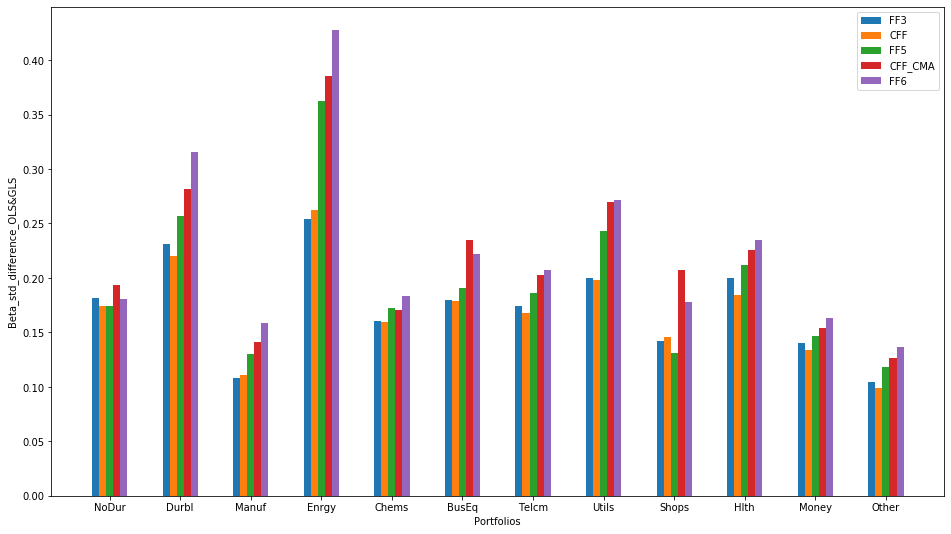

In [26]:
#Using the bar chart to compare the GLS and OLS beta std results
bar_chart_plot(beta_std_bytime-beta_std_bytime_GLS, 0.1, 'Portfolios', 'Beta_std_difference_OLS&GLS')

In [27]:
##Calculate the beta std of WLS
beta_std_bytime_WLS = calc_beta_std(portfolio_return, FF_data, factor_comb, result_table_cols, 'WLS')
beta_std_bytime_WLS

,NoDur,Durbl,Manuf,Enrgy,Chems,BusEq,Telcm,Utils,Shops,Hlth,Money,Other
FF3,5.551115e-17,1.786765e-16,7.771561e-17,8.881784e-17,7.771561e-17,3.903128e-17,1.117162e-16,3.343679e-17,9.436896e-17,4.857226e-17,1.444157e-16,1.221245e-16
CFF,8.333901e-17,2.451743e-16,1.850372e-17,1.202742e-16,6.649773e-17,1.087093e-16,4.654841e-17,3.241764e-17,7.864080e-17,4.743385e-17,7.415943e-17,3.701647e-17
FF5,2.193186e-17,1.308477e-16,7.539852e-17,1.149874e-16,4.782880e-17,6.554777e-17,7.558438e-17,4.491695e-18,3.872151e-17,4.559845e-17,7.948751e-17,4.559845e-17
CFF_CMA,6.740640e-17,6.393695e-17,4.361590e-17,7.137148e-17,7.948751e-17,5.464379e-17,2.478176e-18,2.831317e-17,3.172066e-17,7.335402e-17,7.632783e-17,7.137148e-17
FF6,4.260915e-17,1.739060e-16,9.031404e-17,1.186117e-16,4.163336e-17,6.602791e-17,7.676151e-17,5.255670e-17,5.120145e-17,5.561957e-17,6.852158e-17,2.775558e-17


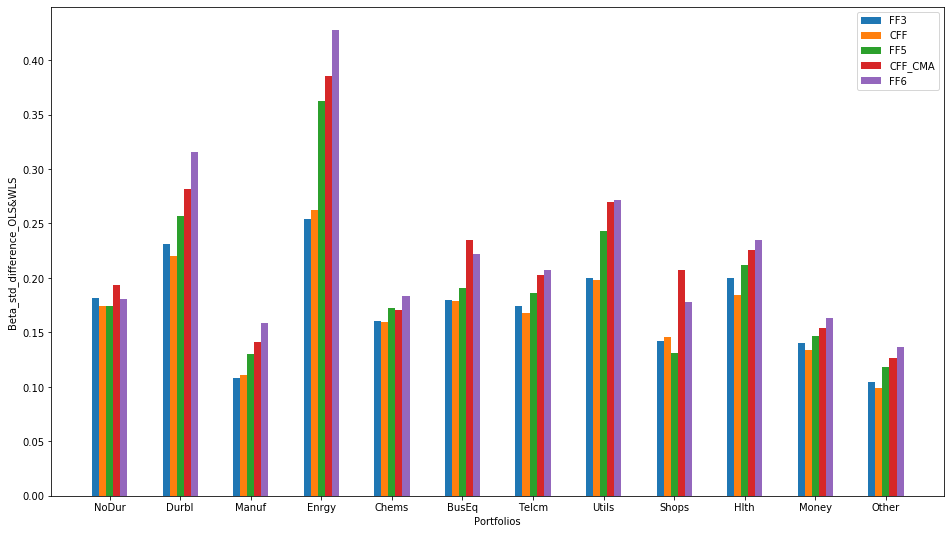

In [28]:
#Using the bar chart to compare the GLS and OLS beta std results
bar_chart_plot(beta_std_bytime-beta_std_bytime_WLS, 0.1, 'Portfolios', 'Beta_std_difference_OLS&WLS')

### Conclusions

* 1. I investigated the reasons that caused the time variation of beta values, and figured out there is no multicollinearity but heteroskedasticity.
* 2. GLS and WLS are applied to the models, which largely reduced the time variation of beta estimation (to almost 0).

# Question 2

*Question Description*
* a. Which industry portfolios are closely related to each other (how many groups exist – a fundamental analyst may say there are two groups - defensive and cyclical)? 
* b. Does this relationship/group composition change through time?
* c. What technique/s can you use to show this – why did you choose your technique over others?

## Answer 2.a

There are two ways I can think of to find the related groups: 1) draw the correlation heatmap to have a straghtforward visualization, and 2) use clustering method to classify the groups

**Correlation Heatmap**

,NoDur,Durbl,Manuf,Enrgy,Chems,BusEq,Telcm,Utils,Shops,Hlth,Money,Other
NoDur,1.000000,0.503426,0.718675,0.489393,0.792430,0.492181,0.626809,0.563380,0.732276,0.708126,0.717492,0.720168
Durbl,0.503426,1.000000,0.754679,0.448901,0.626584,0.625736,0.538846,0.309381,0.701516,0.438105,0.678247,0.754931
Manuf,0.718675,0.754679,1.000000,0.634483,0.844495,0.736314,0.687817,0.450015,0.797959,0.622527,0.814495,0.924291
Enrgy,0.489393,0.448901,0.634483,1.000000,0.550825,0.385683,0.473481,0.481419,0.429325,0.394478,0.559838,0.579819
Chems,0.792430,0.626584,0.844495,0.550825,1.000000,0.573600,0.593237,0.483263,0.731633,0.663732,0.737978,0.813168
BusEq,0.492181,0.625736,0.736314,0.385683,0.573600,1.000000,0.644107,0.239064,0.715793,0.543897,0.595299,0.765419
Telcm,0.626809,0.538846,0.687817,0.473481,0.593237,0.644107,1.000000,0.433767,0.658690,0.568705,0.671109,0.719743
Utils,0.563380,0.309381,0.450015,0.481419,0.483263,0.239064,0.433767,1.000000,0.369660,0.435995,0.446229,0.443071
Shops,0.732276,0.701516,0.797959,0.429325,0.731633,0.715793,0.658690,0.369660,1.000000,0.641604,0.748771,0.832756
Hlth,0.708126,0.438105,0.622527,0.394478,0.663732,0.543897,0.568705,0.435995,0.641604,1.000000,0.640737,0.662822


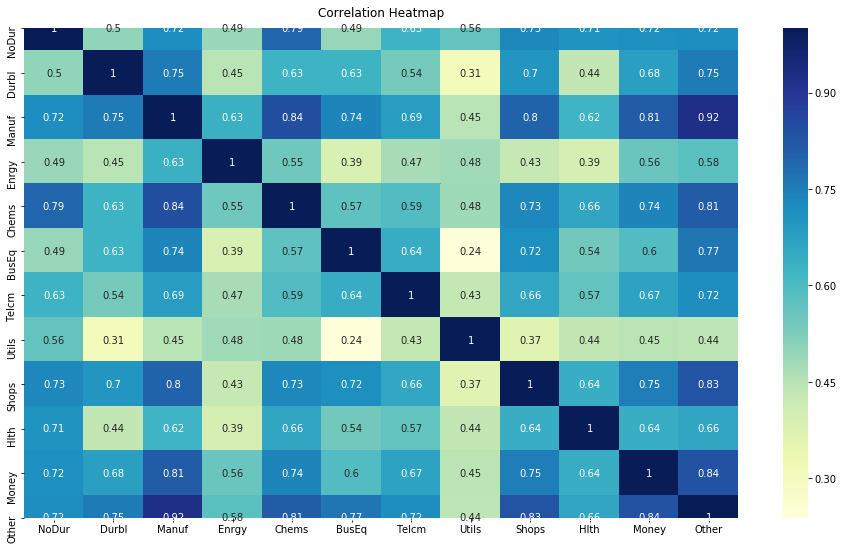

In [29]:
##Draw the correlation heatmap
correlation_method = 'pearson'
plt.figure(figsize=(16, 9))
heatmap = sb.heatmap(portfolio_return.corr(method = correlation_method), cmap="YlGnBu",  annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)
portfolio_return.corr(method = correlation_method)

From the heatmap, we will roughly see 'Other', 'Money', 'Shops', 'Chems' and 'Manuf' are closely related. But the heatmap is not a good way to show the complex relationships between many individuals.

Then in the next step, I will apply hierarchical clustering. But I first used PCA to reduce feature dimensions and create PCA Loading features for each time series (if not, the value at each time point should be a feature). Then I draw the dendrograms to see how the individuals are grouped.

**PCA and Hierarchical Clustering**

In [30]:
##import packages
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.cluster import hierarchy

In [31]:
def run_pca_hierarchical_cluster(
    raw_data, 
    n_components, 
    *, 
    # hierarchical clustering params
    method="ward",
    metric="euclidean",
):
    # normalize data for pca
    scaler = StandardScaler()
    data = scaler.fit_transform(raw_data)
    pca = PCA(n_components).fit(data)
    pca_loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
    
    # use pca_loadings to run hierarchical cluster
    linkage_data = hierarchy.linkage(pca_loadings, method=method, metric=metric)
    hierarchy.dendrogram(linkage_data, labels=raw_data.columns)
    plt.xticks(rotation=90)
    plt.show()

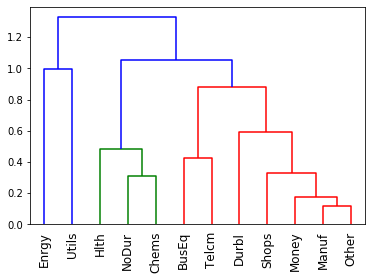

In [32]:
n_components = 5
run_pca_hierarchical_cluster(portfolio_return, n_components)

The dendrogram naturally classified the portfolios into three groups (in different colors), which the red group is similar to the group we get from correlation heatmap. I will use this classification result in the third question.

### Conclusions

By hierarchical clustering, the 12 portfolios are classified into three groups, they are:
* group 1: Enrgy, Utils
* group 2: Hlth, NoDur and Chems
* group 3: BusEq, Telcm, Durbl, Shops, Money, Manuf and Other

## Answer 2.b

I will then tests the time variation of the grouping result. Similar to previous questions, I will cut the entire history into 5 parts and draw the dendrogram into each part. 

clustering result from 198701 to 199404


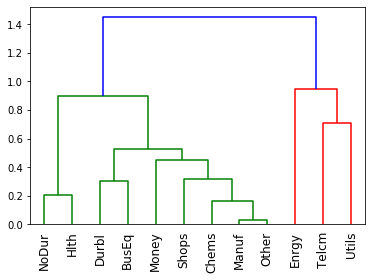

clustering result from 199404 to 200108


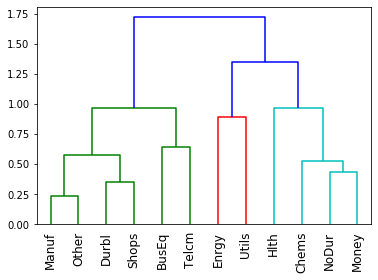

clustering result from 200108 to 200811


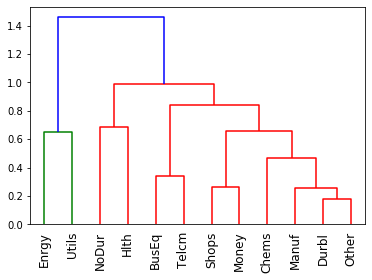

clustering result from 200811 to 201603


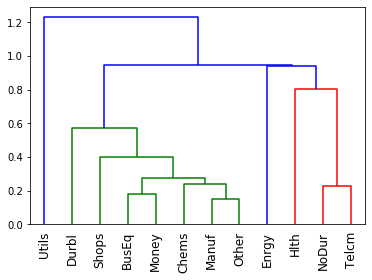

clustering result from 201603 to 202306


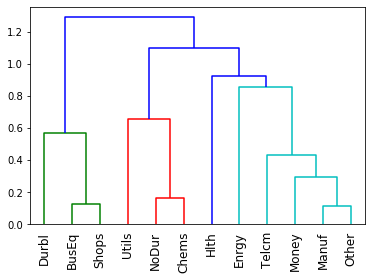

In [33]:
##cut the entire history evenly into 5 periods
times = portfolio_return.index
time_cuts = 5
time_total = times.shape[0]
for i in range(time_cuts):
    start = times[int(i * time_total / time_cuts)]
    end = times[min(int((i+1) * time_total / time_cuts), time_total-1)]
    print(f"clustering result from {start} to {end}")
    run_pca_hierarchical_cluster(portfolio_return.loc[start: end], n_components)

We can tell that the grouping results do change over time, but we cannot tell how big is the difference between different time periods by only visualization. I will use adjusted rand index to measure the similarity between the grouping results from 198701 to 199404 and those from 201603 to 202306.

**Adjusted Rand Index**

In [34]:
from sklearn.metrics.cluster import adjusted_rand_score
label_1987 = [0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0]
label_2016 = [1, 0, 3, 3, 1, 0, 3, 1, 0, 2, 3, 3]
rand_index = adjusted_rand_score(label_1987, label_2016)
print('The Rand index is', round(rand_index, 2))


The Rand index is -0.08


### Conclusions

From the dendrograms in different periods, we can see there exists time variation of the clustering results, and the adjusted rand index value for the testing example is -0.08, which shows the similarity of the clustering results between two time periods is low.

## Answer 2.c

The Adjusted Rand Index (ARI) is a measure of the similarity between two data clusterings. The higher the ARI value, the closer the two clusterings are to each other. It ranges from -1 to 1, where 1 indicates perfect agreement between the two clusterings, 0 indicates a random agreement and -1 indicates that the two clusterings are completely different.

The reasons I choose ARI are: 1) compared to dendrogram visualization, it clearly tells the difference/similarity between two clustering results. 2) compared to Rand Index (RI), it takes into account the fact that some agreement between two clusterings can occur by chance, and it adjusts the Rand Index to account for this possibility and provides more robust evaluations.

# Question 3

*Question Description* <br>
Construct minimum variance portfolio with constraints of not more than 50% allocation to each group that you found in no. 2.  Compare it with equal weighted 12 industry portfolio. Do monthly rebalancing for both.

**Optimization**

I will use the clustering result in question 2 to construct the MVP, that is 'Enrgy' and 'Utils' is a group, 'Hlth' and 'NoDur' and 'Chems' is a group, the rest portfolios is a group.

The optimization problem we are solving is: <br>
                 <center> $ min $ $  w^T\sum w $ <br>
                  $ s.t.$ $ w1+w5+w10 <= 0.5 $ <br>
                  $   w4+w8 <= 0.5 $ <br>
                  $   w2+w3+w6+w7+w9+w11+w12 <= 0.5 $ <br>
                  $   0=<w_i<=1 $ $for $ $i = 1,2,3,...,12 $ <br>
                  $   \sum w_i = 1 $ </center>
                  

In [35]:
#import packages
from scipy.optimize import minimize

## This function is to calculate the portfolio variance with the portfolio weights and covariance matrix
def portfolio_variance(weights,  cov_matrix):
    return np.dot(weights.T, np.dot(cov_matrix, weights))

## This function is to perform optimization on the minimized variance portfolio construction
def minimize_variance_portfolio(expected_returns, cov_matrix):
    num_assets = len(expected_returns)
    # Constraints: sum of weights should be 1, non-negativity of weights, and the group weight<=0.5
    constrains = ({'type': 'eq', 'fun': lambda x:  np.sum(x)-1},
        {'type': 'ineq', 'fun': lambda x: x[0]+x[4]+x[9]-0.5},
         {'type': 'ineq', 'fun': lambda x: x[3]+x[7]-0.5},
        {'type': 'ineq', 'fun': lambda x: x[1]+x[2]+x[5]+x[6]+x[8]+x[10]+x[11]-0.5})
    #boundary of each weight, can change to negative number if we want to short
    bounds = [(0, 1) for x in range(len(expected_returns))] 
    # Initial equal weights (but can be changed to any other starting point)
    initial_weights = np.ones(num_assets) / num_assets

    # Minimize the portfolio variance using the scipy minimize function
    result = minimize(portfolio_variance, initial_weights, args=(cov_matrix,), method='SLSQP', constraints=constrains, bounds = bounds)

    return result.x


In [36]:
##This function is to perform the monthly rebalancing and generate the portfolio values along time 
def rebalance(strategy, portfolio_return):
    #First calculate the market values using returns
    MV = portfolio_return.applymap(lambda x: x+1)
    MV.iloc[0] = [1]*len(MV.columns)
    MV = MV.cumprod(axis = 0)
    
    #Rebalance
    ini_weights = np.array([1/len(MV.columns) for i in range(len(MV.columns))])
    port_value_total  = [1] #set initial portfolio value
    for i in range(1, len(MV.index)):
        if i == 1:
            weights = ini_weights
        port_value = weights.dot(np.array(MV.iloc[i]))
        port_value_total.append(port_value)
        if strategy =='MVP': #minimized variance portfolio
            #I will use a rolling window to calculate the rebalanced weights, using all the previous history information
            weights = minimize_variance_portfolio(list(np.mean(portfolio_return.iloc[:i+1])), portfolio_return.iloc[:i+1].cov())
        elif strategy == 'BH': #buy and hold
            weights = ini_weights
        elif strategy == 'EW': #equal weighted
            weights = (port_value*ini_weights/MV.iloc[i])/sum(port_value*ini_weights/MV.iloc[i])
    return port_value_total

In [37]:
#equal-weighted market value rebalance
EW_port_value = rebalance('EW', portfolio_return)
#buy and hold (no rebalance)
BH_port_value = rebalance('BH', portfolio_return)
#Optimized MVP rebalance
MVP_port_value = rebalance('MVP', portfolio_return)

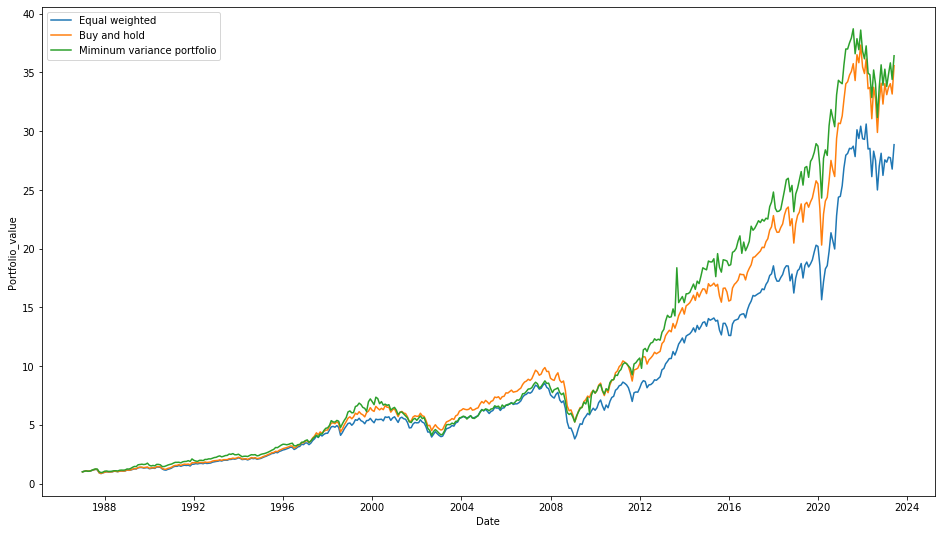

In [38]:
##Plot the portfolio values along time
from datetime import datetime
x=[datetime.strptime(str(portfolio_return.index[i]), '%Y%m') for i in range(len(portfolio_return.index))]
plt.figure(figsize=(16, 9))
plt.plot(x, EW_port_value)
plt.plot(x, BH_port_value)
plt.plot(x, MVP_port_value)
plt.xlabel('Date')
plt.ylabel('Portfolio_value')
plt.legend(['Equal weighted', 'Buy and hold', 'Miminum variance portfolio'])
plt.show()

### Conclusions

* Generally speaking, the performace of the three strategies is MVP>BH>EW.
* It is easy to understand, rebalancing using the MVP weightes helps reduce portfolio variances, and applying the 0.5 threshold constrain further helps increse the divisification of the portfolio (set less weight on the highly correlated portfolios) and reduce the portfolio risk, thus, we see the MVP strategy performs better than EW.
* In most of the periods, MVP performs better than BH, but this is based on the assumption that there is no transaction costs. However, in the real world, we need to take into account the transaction costs, which might lead to a different story.
* One possible reason that BH performs better than EW is that sometimes the development trend of the quick growth portfolios (e.g. Hlth) is curbed by the fixed weight.

# Potential Future Improvement

* 1. When using the t-test to measure the difference of the Adjusted R2 between pair of groups, the sample size is 12, which is relatively insufficient. It is better to test the nomality of the sample distribution, if the sample size is less than 30, it should follow the normal distribution to use the t-test.
* 2. When using GLS, the assumption for residuals is they follow AR(1) model, and the covariance is constructed based on this assumption. But we can further invesitigate whether this assumption is correct and if there is a better approach to estimate the covariance matrix for the residuals.
* 3. For the PCA loadings generation, we manually chose 5 components, but we can further using the explained variation to choose the best number of loadings to have.
* 4. There are a lot of time period divisions used in this solution, but I only evenly divided the whole entire hisitory into several pieces. For further investigation, we can use some representative financial turning point (e.g., crisis) to divide the history. Addionally, we can test if changing the number of time cuts will make a difference to the testing results.
* 5. For the MVP construction, I only considered long positions by setting non-negative boundaries to the portfolio weights, but we can further try to include short positions as well. In addition, I used the whole previous history to calculate the rebalanced weights, we can further set up a fixed length rolling period to calculate the rebalanced weights.
* 6. To better compare the rebalanced trading strategies with buy and hold strategies, we need to consider the transaction cost as well, but for now, we assume there is no transaction cost.